# Bagging Ensembled Models

Bagging ensembles multiple decision trees to enhance the predictive power of a single decision tree. This projects illustrates the use of three bagging alortihms - Random Forest, ExtraTrees, and Bagging. All three models are applied to both regression and classification tasks. 

## Datasets
### Regression:
Source: https://archive.ics.uci.edu/ml/datasets/Superconductivty+Data

instances: 21263

Contains 81 numerical features with one target

### Classification:
source: https://archive.ics.uci.edu/ml/datasets/QSAR+biodegradation

instances: 1055

Contains 41 numerical features with one categorical target

In [ ]:
!wget 'https://raw.githubusercontent.com/profsarang/ThinkingDataScience/main/data/superconductors.csv'

--2022-08-27 07:57:56--  https://raw.githubusercontent.com/profsarang/ThinkingDataScience/main/data/superconductors.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23859780 (23M) [text/plain]
Saving to: ‘superconductors.csv’

superconductors.csv 100%[===================>]  22.75M  --.-KB/s    in 0.07s   

2022-08-27 07:58:00 (347 MB/s) - ‘superconductors.csv’ saved [23859780/23859780]



In [ ]:
!wget 'https://raw.githubusercontent.com/profsarang/ThinkingDataScience/main/data/biodeg.csv'

--2022-08-27 07:58:01--  https://raw.githubusercontent.com/profsarang/ThinkingDataScience/main/data/biodeg.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155987 (152K) [text/plain]
Saving to: ‘biodeg.csv’

biodeg.csv          100%[===================>] 152.33K  --.-KB/s    in 0.003s  

2022-08-27 07:58:01 (51.1 MB/s) - ‘biodeg.csv’ saved [155987/155987]



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
df1=pd.read_csv('/content/superconductors.csv')          #Regression dataset

In [ ]:
df2=pd.read_csv('/content/biodeg.csv', delimiter=';', header=None)   #Multiclass dataset

As the columns names of the biodeg.csv dataset are numerical we have to set them as string and also change the name of the label to be more understandable:

In [ ]:
df2.rename(columns={41:'label'}, inplace=True)

In [ ]:
df2.columns = df2.columns.astype(str)

Set the features and label of the datasets and check their shape:

In [ ]:
features1 = df1.iloc[:,:-1]
label1 = df1.iloc[:,-1]

In [ ]:
features1.shape, label1.shape

((21263, 81), (21263,))

In [ ]:
features2 = df2.iloc[:,:-1]
label2 = df2.iloc[:,-1]

In [ ]:
features2.shape, label2.shape

((1055, 41), (1055,))

Taking care of imbalanced datasets

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(features2, label2)

In [ ]:
X_res.shape

(1398, 41)

In [ ]:
y_res.value_counts()

RB     699
NRB    699
Name: label, dtype: int64

Converting categorical columns

In [ ]:
y_res=y_res.replace('NRB',0).replace('RB',1)

In [ ]:
y_res.value_counts()

1    699
0    699
Name: label, dtype: int64

## Creating training/testing datasets

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train1, X_val1, label_train1, label_val1 = train_test_split(features1, label1, test_size=0.20, random_state=42)

In [ ]:
X_train1.shape, X_val1.shape, label_train1.shape, label_val1.shape

((17010, 81), (4253, 81), (17010,), (4253,))

In [ ]:
X_train2, X_val2, label_train2, label_val2 = train_test_split(X_res, y_res , random_state=42, test_size = 0.2)

In [ ]:
X_train2.shape, X_val2.shape, label_train2.shape, label_val2.shape

((1118, 41), (280, 41), (1118,), (280,))

Let us import some fuctions useful to measure the performance of both models:

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def error_metrics(y_pred,y_val):
  print('MSE: ',mean_squared_error(y_pred,y_val))
  print('RMSE: ',np.sqrt(mean_squared_error(y_pred,y_val)))
  print('Coefficient of determination: ',r2_score(y_pred,y_val))

# Modeling

A few key hyper-parameters: 

- max_features: The number of features to consider when looking for the best split. The default value is 'auto' which means sqrt(n_features).
- max_depth: The maximum depth of the tree. The default value is 'None', which means nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- max_samples: If bootstrap is True, the number of samples to draw from X to train each base estimator.The default value is dataset.shape[0]. (Take into account the number of samples the dataset contains because if it's small it will not be recommended using just a portion of it).

Recommended to use the default values for the following:
- n_jobs: The number of jobs to run in parallel. The default value is -1, which means using all available cores.
- warm_start: Is a crucial and helpful feature when evaluating in several number of trees, because it allows building bigger trees just by adding more trees to the previous model, saving significant time. The default value is True.
- oob_score: If True computes the out-of-bag.  
- min_samples_split: The minimum number of samples required to split an internal node. The default value is 2.

Required to set:
- n_estimators: The number of trees in the forest. Larger value increases the complexity and may result in overfitting. 

## Random Forest

### Regressor

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

We will evaluate the regressor with a set of nine values for the number of estimators.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
RFreg = RandomForestRegressor(oob_score=True,
                              random_state=42,
                              warm_start=True,
                              n_jobs=-1)
oob_list = list()
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300]:
    RFreg.set_params(n_estimators=n_trees)
    RFreg.fit(X_train1, label_train1)
    oob_error = 1 - RFreg.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')
rf_oob_df

,oob
n_trees,
15.0,0.097827
20.0,0.088971
30.0,0.084432
40.0,0.082569
50.0,0.081271
100.0,0.078429
150.0,0.077568
200.0,0.077095
300.0,0.076590


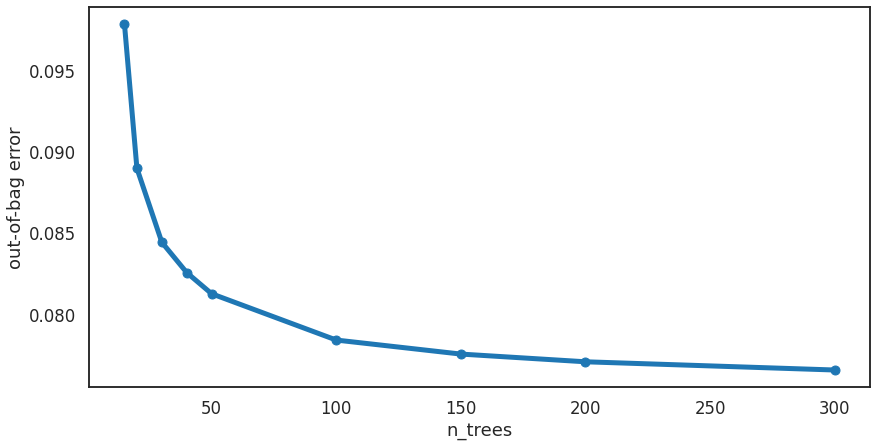

In [ ]:
sns.set_context('talk')
sns.set_style('white')

ax = rf_oob_df.plot(legend=False, marker='o', figsize=(14, 7), linewidth=5)
ax.set(ylabel='out-of-bag error');

We will build the model for 300, though 100 or 150 looks a good figure. 

In [ ]:
RFreg_300 = RandomForestRegressor(n_estimators=300
                                  ,oob_score=True 
                                  ,random_state=42
                                  ,n_jobs=-1)

RFreg_300.fit(X_train1, label_train1)
oob_error300 = 1 - RFreg_300.oob_score_
oob_error300

0.07659017671460666

### Effect of different hyper-parameters

In [ ]:
RFreg_300 = RandomForestRegressor(n_estimators=300,oob_score=True,random_state=42,n_jobs=-1,
                                  max_features='log2')

RFreg_300.fit(X_train1, label_train1)
oob_error300 = 1 - RFreg_300.oob_score_
oob_error300

0.07458068274131346

In [ ]:
RFreg_300 = RandomForestRegressor(n_estimators=300,oob_score=True,random_state=42,n_jobs=-1,
                                  max_depth=3)

RFreg_300.fit(X_train1, label_train1)
oob_error300 = 1 - RFreg_300.oob_score_
oob_error300

0.29041541826443185

In [ ]:
RFreg_300 = RandomForestRegressor(n_estimators=300,oob_score=True,random_state=42,n_jobs=-1,
                                  max_samples=0.7)

RFreg_300.fit(X_train1, label_train1)
oob_error300 = 1 - RFreg_300.oob_score_
oob_error300

0.07787537004573342

### Inference

In [ ]:
label_pred_reg_rf=RFreg_300.predict(X_val1)

In [ ]:
error_metrics(label_pred_reg_rf,label_val1)

MSE:  82.71185919807532
RMSE:  9.094606049635978
Coefficient of determination:  0.920360729478271


### Classifier

This model will be similar to the previous one, same number of trees and features.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RFcla = RandomForestClassifier(oob_score=True,
                               random_state=42,
                               warm_start=True,
                               n_jobs=-1)
oob_list = list()
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300]:
    RFcla.set_params(n_estimators=n_trees)
    RFcla.fit(X_train2, label_train2)
    oob_error = 1 - RFcla.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')
rf_oob_df

,oob
n_trees,
15.0,0.117174
20.0,0.112701
30.0,0.110018
40.0,0.103757
50.0,0.106440
100.0,0.108229
150.0,0.104651
200.0,0.101968
300.0,0.097496


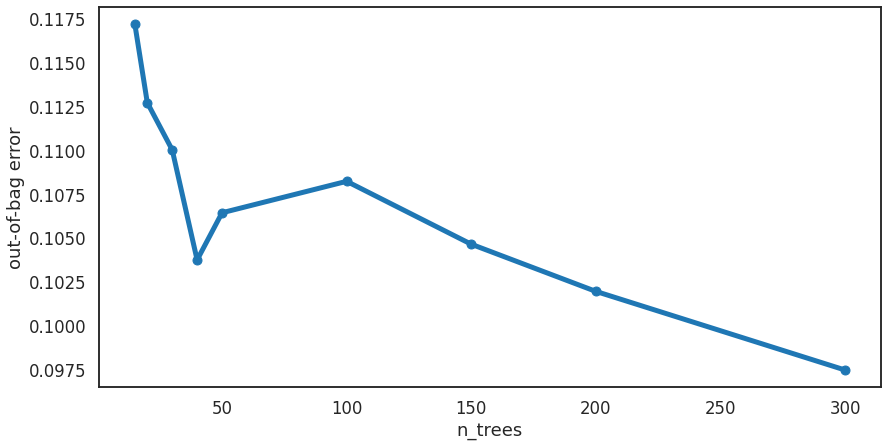

In [ ]:
sns.set_context('talk')
sns.set_style('white')

ax = rf_oob_df.plot(legend=False, marker='o', figsize=(14, 7), linewidth=5)
ax.set(ylabel='out-of-bag error');

This time 300 trees had the lowest error and there was a significant difference with 250, which is why we will create a new model as follows:

In [ ]:
RFcla_300 = RandomForestClassifier(n_estimators=300
                                  ,oob_score=True 
                                  ,random_state=42
                                  ,n_jobs=-1)

RFcla_300.fit(X_train2, label_train2)
oob_error300 = 1 - RFcla_300.oob_score_
oob_error300

0.0974955277280859

### Effect of different hyper-parameters

In [ ]:
RFcla_300 = RandomForestClassifier(n_estimators=300,oob_score=True,random_state=42,n_jobs=-1,
                                   max_features='log2')

RFcla_300.fit(X_train2, label_train2)
oob_error300 = 1 - RFcla_300.oob_score_
oob_error300

0.10286225402504467

In [ ]:
RFcla_300 = RandomForestClassifier(n_estimators=300,oob_score=True,random_state=42,n_jobs=-1,
                                   max_depth=6)

RFcla_300.fit(X_train2, label_train2)
oob_error300 = 1 - RFcla_300.oob_score_
oob_error300

0.11270125223613592

### Inference

In [ ]:
label_pred_cla_rf=RFcla_300.predict(X_val2)

In [ ]:
print(classification_report(label_val2,label_pred_cla_rf))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       143
           1       0.89      0.91      0.90       137

    accuracy                           0.90       280
   macro avg       0.90      0.90      0.90       280
weighted avg       0.90      0.90      0.90       280



## Extremely Randomized Trees

### Regressor

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
ETreg = ExtraTreesRegressor(oob_score=True,
                            random_state=42,
                            warm_start=True,
                            n_jobs=-1,
                            bootstrap=True)
oob_list = list()
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300]:
    ETreg.set_params(n_estimators=n_trees)
    ETreg.fit(X_train1, label_train1)
    oob_error = 1 - ETreg.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

et_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')
et_oob_df

,oob
n_trees,
15.0,0.093199
20.0,0.084015
30.0,0.079740
40.0,0.077705
50.0,0.076833
100.0,0.074722
150.0,0.073790
200.0,0.073336
300.0,0.072881


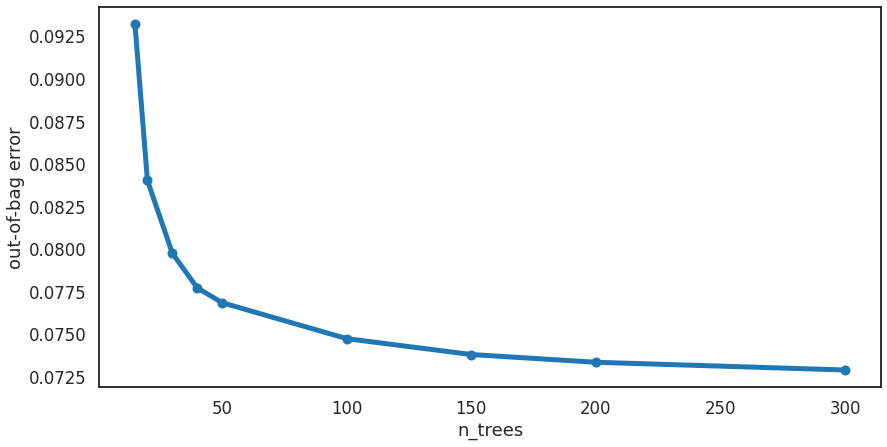

In [ ]:
sns.set_context('talk')
sns.set_style('white')

ax = et_oob_df.plot(legend=False, marker='o', figsize=(14, 7), linewidth=5)
ax.set(ylabel='out-of-bag error');

In [ ]:
ETreg_300 = ExtraTreesRegressor(n_estimators=300,
                                oob_score=True, 
                                random_state=42,
                                n_jobs=-1,
                                bootstrap=True)

ETreg_300.fit(X_train1, label_train1)
oob_error300 = 1 - ETreg_300.oob_score_
oob_error300

0.072881398959322

### Effect of different hyper-parameters

In [ ]:
ETreg_300 = ExtraTreesRegressor(n_estimators=300,oob_score=True,random_state=42,n_jobs=-1,bootstrap=True,
                                max_features='log2')

ETreg_300.fit(X_train1, label_train1)
oob_error300 = 1 - ETreg_300.oob_score_
oob_error300

0.07450498706018704

In [ ]:
ETreg_300 = ExtraTreesRegressor(n_estimators=300,oob_score=True,random_state=42,n_jobs=-1,bootstrap=True,
                                max_depth=3)

ETreg_300.fit(X_train1, label_train1)
oob_error300 = 1 - ETreg_300.oob_score_
oob_error300

0.31203882206742684

In [ ]:
ETreg_300 = ExtraTreesRegressor(n_estimators=300,oob_score=True,random_state=42,n_jobs=-1,bootstrap=True,
                                max_samples=0.7)

ETreg_300.fit(X_train1, label_train1)
oob_error300 = 1 - ETreg_300.oob_score_
oob_error300

0.07435245575384941

### Inference

In [ ]:
label_pred_reg_et=ETreg_300.predict(X_val1)

In [ ]:
error_metrics(label_pred_reg_et,label_val1)

MSE:  80.45131203496905
RMSE:  8.96946553786618
Coefficient of determination:  0.9226136058439495


### Classifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
ETcla = ExtraTreesClassifier(oob_score=True,
                             random_state=42,
                             warm_start=True,
                             n_jobs=-1,
                             bootstrap=True)
oob_list = list()
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300]:
    ETcla.set_params(n_estimators=n_trees)
    ETcla.fit(X_train2, label_train2)
    oob_error = 1 - ETcla.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

et_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')
et_oob_df

,oob
n_trees,
15.0,0.118962
20.0,0.113596
30.0,0.112701
40.0,0.105546
50.0,0.104651
100.0,0.095707
150.0,0.098390
200.0,0.098390
300.0,0.094812


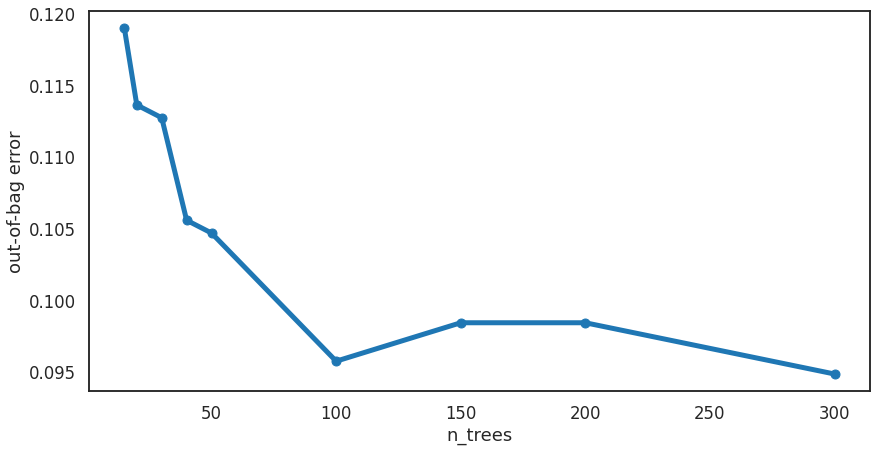

In [ ]:
sns.set_context('talk')
sns.set_style('white')

ax = et_oob_df.plot(legend=False, marker='o', figsize=(14, 7), linewidth=5)
ax.set(ylabel='out-of-bag error');

In [ ]:
ETcla_300 = ExtraTreesClassifier(n_estimators=300
                                  ,oob_score=True 
                                  ,random_state=42
                                  ,n_jobs=-1
                                  ,bootstrap=True)

ETcla_300.fit(X_train2, label_train2)
oob_error300 = 1 - ETcla_300.oob_score_
oob_error300

0.0948121645796064

### Effect of different hyper-parameters

In [ ]:
ETcla_300 = ExtraTreesClassifier(n_estimators=300,oob_score=True,random_state=42,n_jobs=-1,bootstrap=True,
                                 max_features='log2')

ETcla_300.fit(X_train2, label_train2)
oob_error300 = 1 - ETcla_300.oob_score_
oob_error300

0.09302325581395354

In [ ]:
ETcla_300 = ExtraTreesClassifier(n_estimators=300,oob_score=True,random_state=42,n_jobs=-1,bootstrap=True,
                                 max_depth=6)

ETcla_300.fit(X_train2, label_train2)
oob_error300 = 1 - ETcla_300.oob_score_
oob_error300

0.14579606440071557

### Inference

In [ ]:
label_pred_cla_et=ETcla_300.predict(X_val2)

In [ ]:
print(classification_report(label_val2,label_pred_cla_et))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87       143
           1       0.82      0.96      0.88       137

    accuracy                           0.88       280
   macro avg       0.88      0.88      0.87       280
weighted avg       0.89      0.88      0.87       280



Overall, Random Forest slightly outperformed Extra Trees model in both classification and regression for these datasets.

## Bagging

This models allows the use to set a base estimator, other than a decision tree as in earlier algorithms.

### Regressor

### SVC estimator

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor

Bagreg_100 = BaggingRegressor(base_estimator=SVR(),
                              n_estimators=100,
                              oob_score=True, 
                              random_state=42,
                              n_jobs=-1,
                              bootstrap=True)

Bagreg_100.fit(X_train1, label_train1)
oob_error100 = 1 - Bagreg_100.oob_score_
oob_error100

0.5260148669127701

### Dummy regressor estimator

In [ ]:
Bagreg_100 = BaggingRegressor(base_estimator=DummyRegressor(),
                              n_estimators=100,
                              oob_score=True, 
                              random_state=42,
                              n_jobs=-1,
                              bootstrap=True)

Bagreg_100.fit(X_train1, label_train1)
oob_error100 = 1 - Bagreg_100.oob_score_
oob_error100

1.0001160275212564

### K-Neighors estimator

In [ ]:
Bagreg_100 = BaggingRegressor(base_estimator=KNeighborsRegressor(),
                              n_estimators=100,
                              oob_score=True, 
                              random_state=42,
                              n_jobs=-1,
                              bootstrap=True)

Bagreg_100.fit(X_train1, label_train1)
oob_error100 = 1 - Bagreg_100.oob_score_
oob_error100

0.11777286532472597

Inference

In [ ]:
label_pred_reg_bag=Bagreg_100.predict(X_val1)

In [ ]:
error_metrics(label_pred_reg_bag,label_val1)

MSE:  126.49330690512342
RMSE:  11.246924330905912
Coefficient of determination:  0.8799453668939431


### Classifier

### SVC estimator

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

Bagcla_100 = BaggingClassifier(base_estimator=SVC(),
                               n_estimators=100,
                               oob_score=True, 
                               random_state=42,
                               n_jobs=-1,
                               bootstrap=True)

Bagcla_100.fit(X_train2, label_train2)
oob_error100 = 1 - Bagcla_100.oob_score_
oob_error100

0.1636851520572451

### Logistic regressor estimator

In [ ]:
Bagcla_100 = BaggingClassifier(base_estimator=LogisticRegression(),
                               n_estimators=100,
                                oob_score=True, 
                                random_state=42,
                                n_jobs=-1,
                                bootstrap=True)

Bagcla_100.fit(X_train2, label_train2)
oob_error100 = 1 - Bagcla_100.oob_score_
oob_error100

0.11717352415026838

### K-Neighbors estimator

In [ ]:
Bagcla_100 = BaggingClassifier(base_estimator=KNeighborsClassifier(),
                               n_estimators=100,
                                oob_score=True, 
                                random_state=42,
                                n_jobs=-1,
                                bootstrap=True)

Bagcla_100.fit(X_train2, label_train2)
oob_error100 = 1 - Bagcla_100.oob_score_
oob_error100

0.1520572450805009

Inference

In [ ]:
label_pred_cla_bag=Bagcla_100.predict(X_val2)

In [ ]:
print(classification_report(label_val2,label_pred_cla_bag))

              precision    recall  f1-score   support

           0       0.96      0.73      0.83       143
           1       0.78      0.97      0.86       137

    accuracy                           0.85       280
   macro avg       0.87      0.85      0.85       280
weighted avg       0.87      0.85      0.85       280

